# Introduction
Most of the code and text originated from the WiDS Datathon Workshop 2025, organized by Sharut Gupta (MIT CSAIL), Arushi Jain (Microsoft), and Claire Tinker (IBM). I edited some of the text and only focus on feature engineering to build the final training and testing tables.

## Learning Goals:
* Data cleaning and preprocessing for model development and analysis
* Understanding correlations
* Regression model selection (statistical, machine learning)
* Regression model fitting/testing (cross validation, avoiding over/underfitting, stratification of data during training)
* Feature Engineering and Selection
* Explaining factors that drive the performance of the model
* Multi-outcome prediction

## Load the required libraries

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plotting libraries
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns

# math libraries
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Warnings
import warnings
warnings.filterwarnings("ignore")

## Load & Explore the Data

From the `TRAIN_NEW` folder, we will load:
- Functional MRI connectome data
- Quantitative metadata (e.g., test scores)
- Categorical metadata (e.g., demographics)
- Targets: ADHD diagnosis & Sex

In [16]:
# === Load TRAIN data ===
train_path = "/Users/Haley/Desktop/WiDs Datathon/widsdatathon2025/TRAIN_NEW"
connectome_train = pd.read_csv(f"{train_path}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quant_meta_train = pd.read_excel(f"{train_path}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat_meta_train = pd.read_excel(f"{train_path}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
targets_train = pd.read_excel(f"{train_path}/TRAINING_SOLUTIONS.xlsx")


# Check shapes
print("Train Connectome:", connectome_train.shape)
print("Train Quantitative metadata:", quant_meta_train.shape)
print("Train Categorical metadata:", cat_meta_train.shape)
print("Train Targets:", targets_train.shape)

# === Load TEST data ===
test_path = "/Users/Haley/Desktop/WiDs Datathon/widsdatathon2025/TEST"
connectome_test = pd.read_csv(f"{test_path}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quant_meta_test = pd.read_excel(f"{test_path}/TEST_QUANTITATIVE_METADATA.xlsx")
cat_meta_test = pd.read_excel(f"{test_path}/TEST_CATEGORICAL.xlsx")


# Check shapes
print("Test Connectome:", connectome_test.shape)
print("Test Quantitative metadata:", quant_meta_test.shape)
print("Test Categorical metadata:", cat_meta_test.shape)

Train Connectome: (1213, 19901)
Train Quantitative metadata: (1213, 19)
Train Categorical metadata: (1213, 10)
Train Targets: (1213, 3)
Test Connectome: (304, 19901)
Test Quantitative metadata: (304, 19)
Test Categorical metadata: (304, 10)


Note that the definitions of the categorical, quantitative, and target features are listed in the data dictionary imported below:

In [17]:
#Load File
data_dict = pd.read_excel('/Users/Haley/Desktop/WiDs Datathon/widsdatathon2025/Data Dictionary.xlsx')

In [18]:
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 = 10th right
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored into total score but provides item level information),int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a way to understand your dataset by looking at its patterns, trends, and relationships. It helps identify missing data, outliers, and how variables interact.

## Categorical Features
Our categorical features include:
* Enrollment year (categorical)
* Study site (categorical)
* Pre-Interview- Demographics/Family - Ethnicity (categorical)
* Pre-Interview- Demographics/Family - Race (categorical)
* MRI location (categorical)
* Education level of Parent 1 (quantitative)
* Occupation level of Parent 1 (categorical)
* Education level of Parent 2 (quantitative)
* Occupation level of Parent 2 (categorical)

Use `.info()` and `.describe()` to summarize each dataset.

In [19]:
cat_meta_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1159 non-null   float64
 5   MRI_Track_Scan_Location           1210 non-null   float64
 6   Barratt_Barratt_P1_Edu            1198 non-null   float64
 7   Barratt_Barratt_P1_Occ            1182 non-null   float64
 8   Barratt_Barratt_P2_Edu            1015 non-null   float64
 9   Barratt_Barratt_P2_Occ            991 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 94.9+ KB


### Enrollment Year

Ideally we would expect that the number of each target is about the same each year, but this does not seem to be the case.

<Axes: xlabel='Basic_Demos_Enroll_Year', ylabel='Count'>

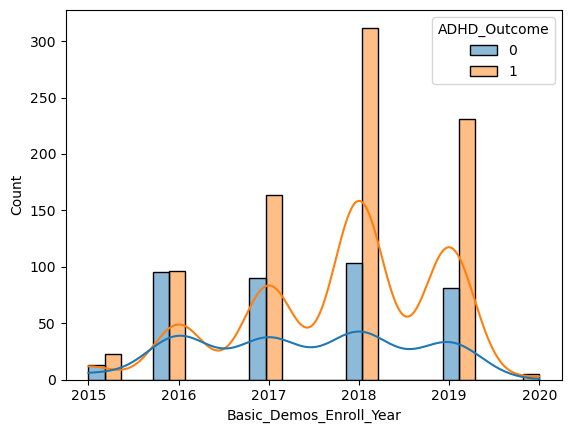

In [20]:
cat_meta_merge_df = cat_meta_train.loc[:,['Basic_Demos_Enroll_Year','participant_id']].merge(
    targets_train, on = 'participant_id', how = 'left'
).drop(columns = ['participant_id'])
cat_meta_merge_df.head()
sns.histplot(data=cat_meta_merge_df, x="Basic_Demos_Enroll_Year", hue="ADHD_Outcome", multiple="dodge", kde=True)

### Study site and MRI location

In [21]:
pd.set_option('display.max_colwidth', None)
data_dict.loc[data_dict["Field"]=="Basic_Demos_Study_Site","Labels"]

24    1=Staten Island \n2=MRV\n3=Midtown\n4=Harlem\n5=SI RUMC
Name: Labels, dtype: object

In [22]:

data_dict.loc[data_dict["Field"]=="MRI_Track_Scan_Location","Labels"]

27    1=Staten Island\n2=RUBIC\n3=CBIC\n4=CUNY
Name: Labels, dtype: object

In [23]:
(
    cat_meta_train
    .loc[:,['Basic_Demos_Study_Site','MRI_Track_Scan_Location']]
    .value_counts(dropna=False)
    .reset_index()
    .sort_values("Basic_Demos_Study_Site")
)

,Basic_Demos_Study_Site,MRI_Track_Scan_Location,count
0,1,2.0,408
2,1,1.0,161
5,1,3.0,79
9,1,NaN,3
11,1,4.0,1
7,2,1.0,11
1,3,3.0,301
3,3,2.0,121
8,3,1.0,7
12,3,4.0,1


We may want to drop individuals from MRV (Basic_Demos_Study_Site=2) since there are only 11. We can fill individuals with Na for the MRI_Track_Scan_Location to 2.0 since they are all from Basic Demo Study Site 1 and most individuals from that study site went to RUBIC (MRI_Track_Scan_Location=2.0)

### Race & Ethnicity

Consider the feature `PreInt_Demos_Fam_Child_Ethnicity` and `PreInt_Demos_Fam_Child_Race`

In [24]:
data_dict.loc[data_dict["Field"]=="PreInt_Demos_Fam_Child_Ethnicity","Labels"]

25    0= Not Hispanic or Latino\n1= Hispanic or Latino\n2= Decline to specify\n3= Unknown
Name: Labels, dtype: object

In [25]:

data_dict.loc[data_dict["Field"]=="PreInt_Demos_Fam_Child_Race","Labels"]

26    0= White/Caucasian\n1= Black/African American\n2= Hispanic\n3= Asian\n4= Indian\n5= Native American Indian\n6= American Indian/Alaskan Native\n7= Native Hawaiian/Other Pacific Islander\n8= Two or more races\n9= Other race\n10= Unknown\n11=Choose not to specify
Name: Labels, dtype: object

In [26]:
(
    cat_meta_train
    .loc[:,['PreInt_Demos_Fam_Child_Ethnicity','PreInt_Demos_Fam_Child_Race']]
    .value_counts(dropna=False)
    .reset_index()
    .sort_values(["PreInt_Demos_Fam_Child_Ethnicity","count"], ascending=[True,False])
)

,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,count
0,0.0,0.0,497
1,0.0,1.0,136
3,0.0,8.0,90
9,0.0,3.0,23
11,0.0,NaN,13
12,0.0,9.0,10
13,0.0,4.0,8
2,1.0,2.0,125
4,1.0,8.0,80
5,1.0,0.0,45


We can use Ethnicity to impute race and visa versa if the values are missing. We can impute both values using the majority.

### Parent Occupations


Notice in the categorical training dataset, `991` of the participants have a Non-Null value in the `Barratt_Barratt_P2_Occ` column. Given that we have `1213` participants total, this means that there are `222` null values in the `Barratt_Barratt_P2_Occ` column. We will need to handle these null values later. 

Looking at `Barratt_Barratt_P1_Occ` and `Barratt_Barratt_P2_Occ` it seems that the higher values require higher education levels

In [27]:
pd.set_option('display.max_colwidth', None)
data_dict.loc[data_dict["Field"]=="Barratt_Barratt_P1_Occ","Labels"]

29    0=Homemaker, stay at home parent.\n5=Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.\n10=Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.\n15=Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.\n20=Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.\n25=Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.\n30=Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.\n35=Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.\n40=Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementar

In [28]:

data_dict.loc[data_dict["Field"]=="Barratt_Barratt_P1_Edu","Labels"]

28    3=Less than 7th grade\n6=Junior high/Middle school (9th grade)\n9=Partial high school (10th or 11th grade)\n12=High school graduate\n15=Partial college (at least one year)\n18=College education\n21=Graduate degree
Name: Labels, dtype: object

count    2173.000000
mean       27.694432
std        15.693002
min         0.000000
25%        15.000000
50%        35.000000
75%        40.000000
max        45.000000
dtype: float64


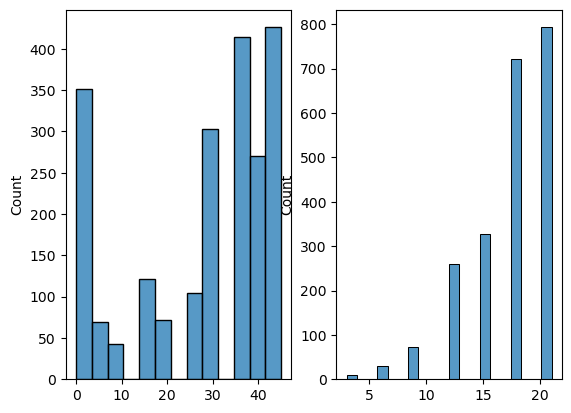

In [29]:
bb_occ = pd.concat([cat_meta_train['Barratt_Barratt_P1_Occ'],cat_meta_train['Barratt_Barratt_P2_Occ']])
print(bb_occ.describe())
bb_edu = pd.concat([cat_meta_train['Barratt_Barratt_P1_Edu'],cat_meta_train['Barratt_Barratt_P2_Edu']])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1 = sns.histplot(data=bb_occ, ax=ax1)
ax2 = sns.histplot(data=bb_edu, ax=ax2)

It looks like our data is biased to individuals where parents have higher education but are either at higher or lower levels of occupation. I am curious if the occupation values match up with the level of educaton. You may expect this but some people with higher educations may choose jobs at the lower levels if they have the means. Below I look at all parents independent of their coparent.

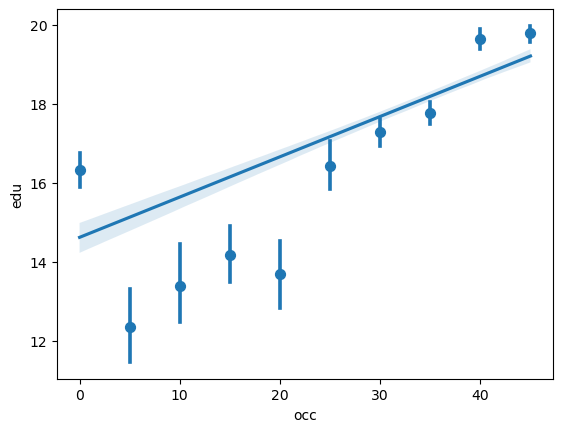

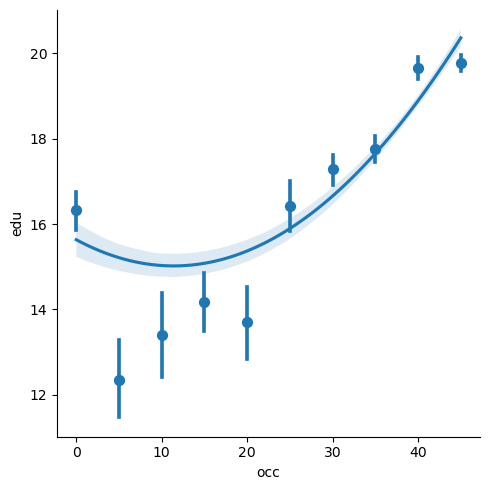

In [30]:
occ_edu_df = pd.DataFrame([bb_occ.tolist(), bb_edu.tolist()],index=["occ","edu"]).transpose().dropna()
sns.regplot(data=occ_edu_df, x="occ", y="edu", x_estimator=np.mean)
sns.lmplot(data=occ_edu_df, x="occ", y="edu", x_estimator=np.mean, order=2)

Below I look at correlation with the high education and job level across parents

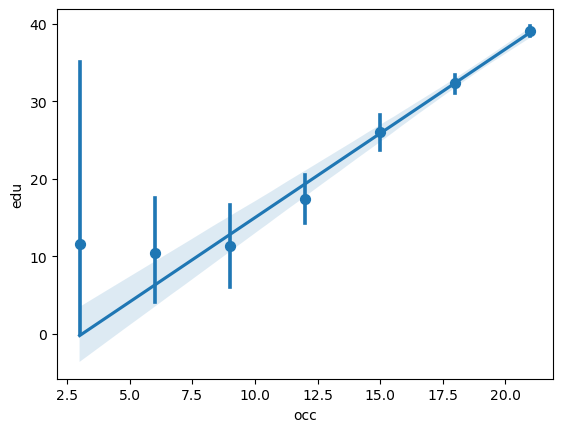

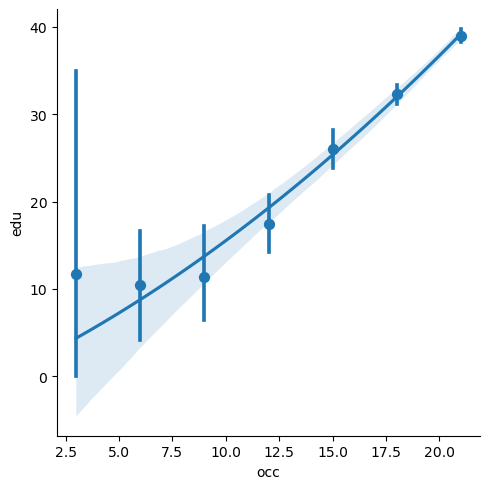

In [31]:
bb_occ = cat_meta_train[['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']].max(axis=1)
bb_edu = cat_meta_train[['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']].max(axis=1)
occ_edu_df = pd.DataFrame([bb_occ, bb_edu],index=["occ","edu"]).transpose().dropna()
sns.regplot(data=occ_edu_df, x="occ", y="edu", x_estimator=np.mean)
sns.lmplot(data=occ_edu_df, x="occ", y="edu", x_estimator=np.mean, order=2)

So my guess is that individuals with high education levels have either high stress jobs or low stress jobs and not in between. At least thats what the data seems to show, but we have limited data of individuals with less education.

I was also curious about the correlation between single parents and ADHD.

In [32]:
cat_meta_train['single_parent'] = (
    (
        (cat_meta_train['Barratt_Barratt_P1_Edu'].notnull()) | 
        (cat_meta_train['Barratt_Barratt_P1_Occ'].notnull())
    ) &
    (cat_meta_train['Barratt_Barratt_P2_Edu'].isnull()) & 
    (cat_meta_train['Barratt_Barratt_P2_Occ'].isnull())
).astype(int)

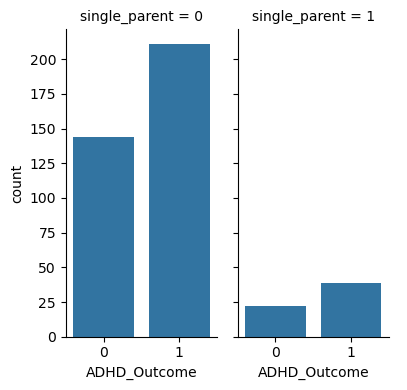

In [33]:
cat_meta_merge_df = cat_meta_train.loc[:,['single_parent','participant_id']].merge(
    targets_train, on = 'participant_id', how = 'left'
).drop(columns = ['participant_id'])
cat_meta_merge_df.head()
sns.catplot(
    (cat_meta_merge_df
    .loc[cat_meta_merge_df['Sex_F'] == 1, :]
    .value_counts().reset_index()
    ), kind="bar",
    x="ADHD_Outcome", y="count", col="single_parent",
    height=4, aspect=.5,
)

It looks like females of single parents are more likely to have ADHD but our sample is small

## Quantitative Features
Our quantitative features include:
* Laterality Index (Score)
* Color vision test score
* Corporal Punishment Score
* Inconsistent Discipline Score
* Involvement Score
* Other Discipline Practices Score (Not factored into total score but provides item level information)
* Poor Monitoring/Supervision Score
* Positive Parenting Score
* Conduct problems scale
* Total Difficulties Score
* Emotional Problems Scale
* Externalizing Score
* Generating Impact Scores
* Hyperactivity Scale
* Internalizing Score
* Peer Problems Scale
* Prosocial Scale
* Age at time of MRI scan

In [34]:
print(quant_meta_train.isna().sum())
print(quant_meta_train.isna().sum().sum())

participant_id                  0
EHQ_EHQ_Total                  13
ColorVision_CV_Score           23
APQ_P_APQ_P_CP                 12
APQ_P_APQ_P_ID                 12
APQ_P_APQ_P_INV                12
APQ_P_APQ_P_OPD                12
APQ_P_APQ_P_PM                 12
APQ_P_APQ_P_PP                 12
SDQ_SDQ_Conduct_Problems        9
SDQ_SDQ_Difficulties_Total      9
SDQ_SDQ_Emotional_Problems      9
SDQ_SDQ_Externalizing           9
SDQ_SDQ_Generating_Impact       9
SDQ_SDQ_Hyperactivity           9
SDQ_SDQ_Internalizing           9
SDQ_SDQ_Peer_Problems           9
SDQ_SDQ_Prosocial               9
MRI_Track_Age_at_Scan         360
dtype: int64
549


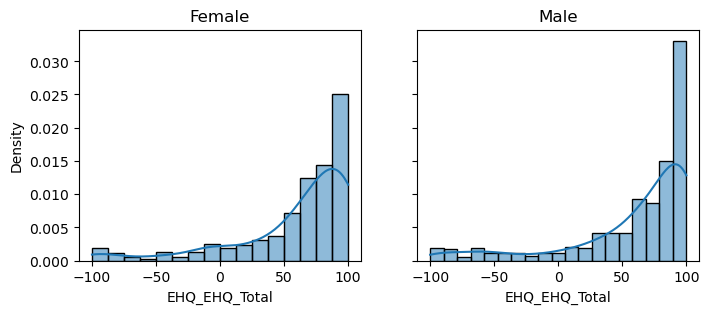

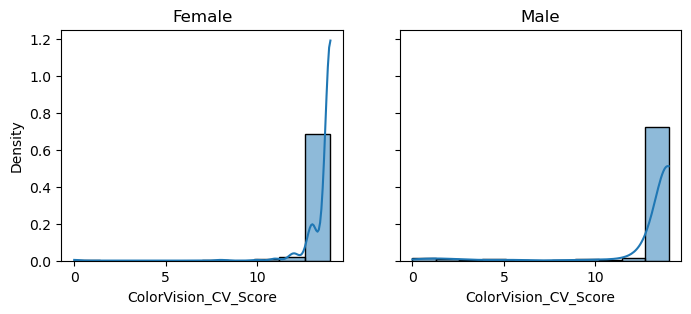

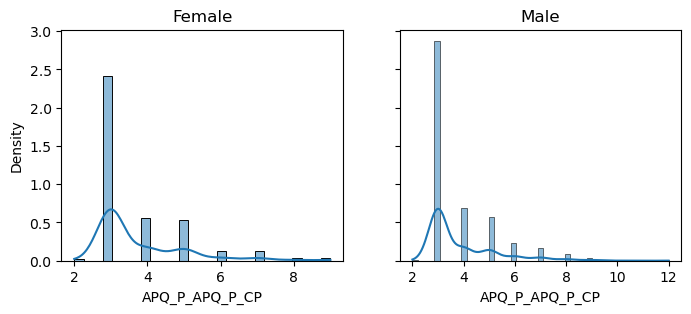

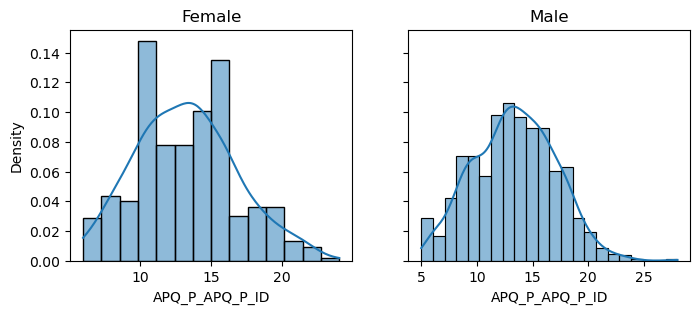

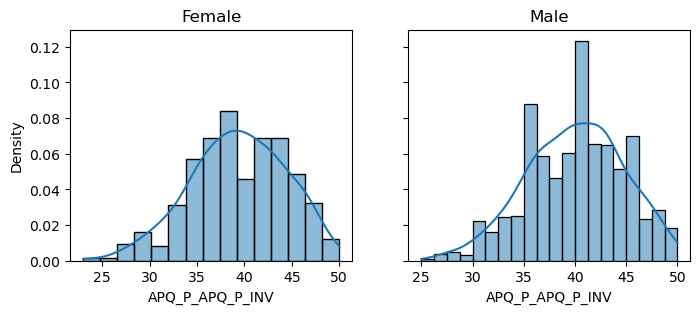

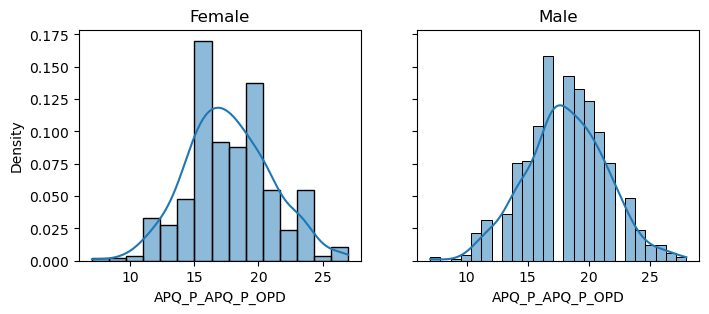

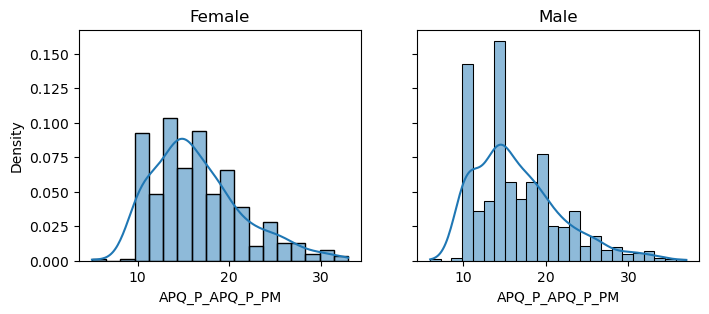

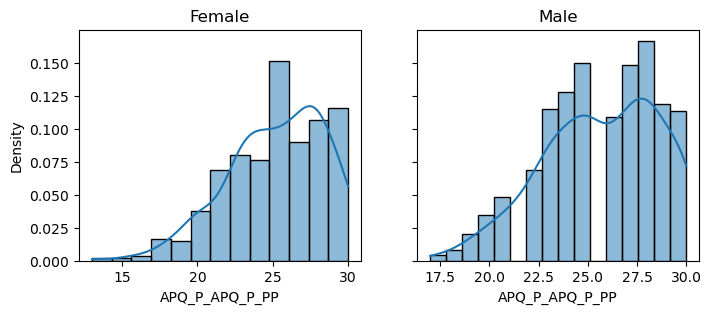

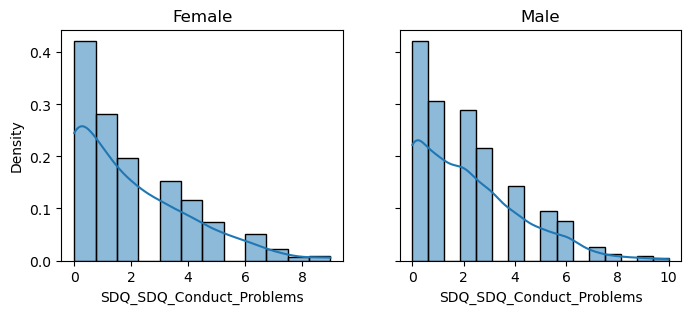

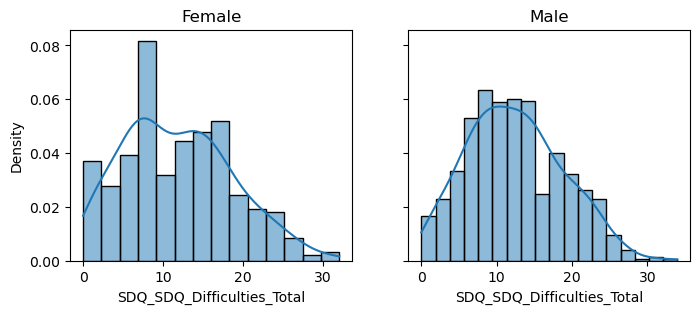

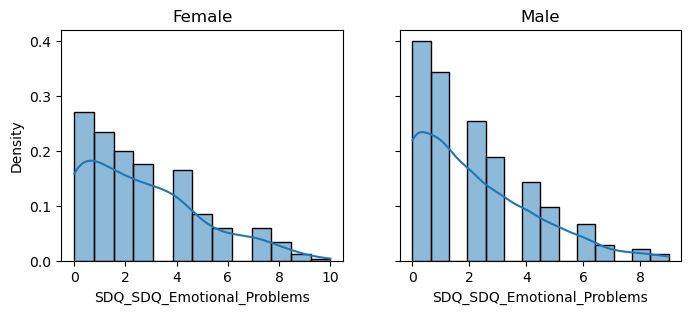

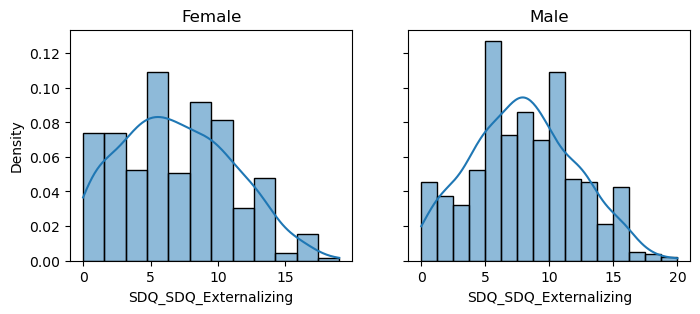

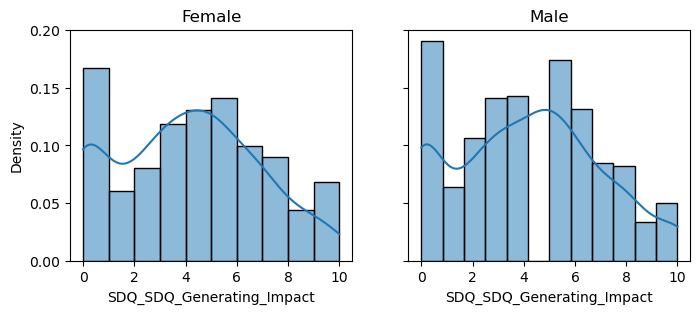

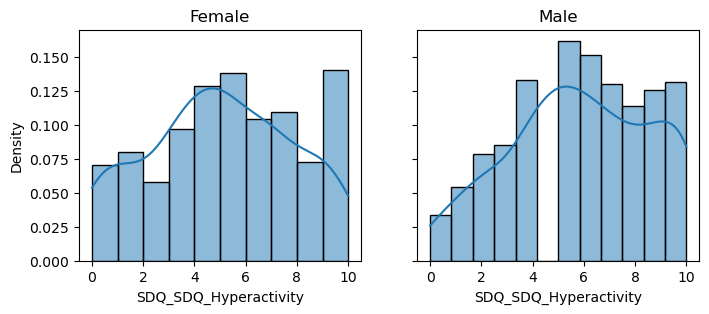

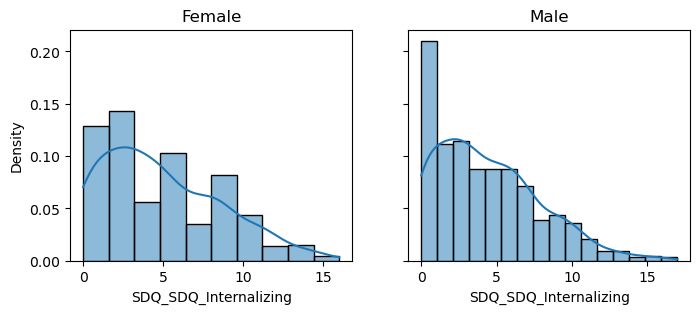

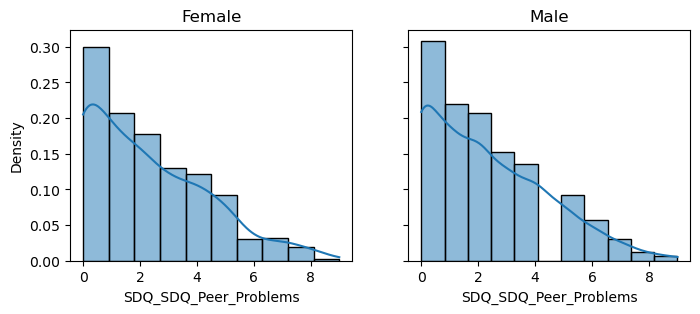

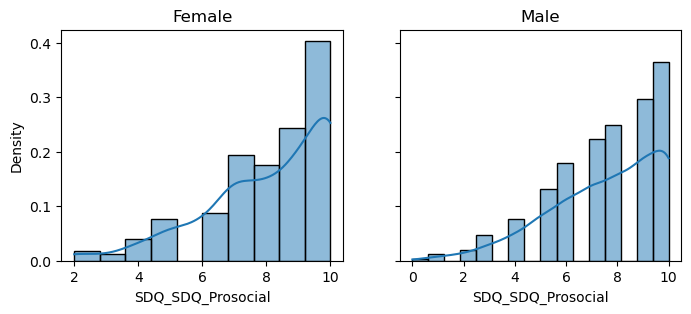

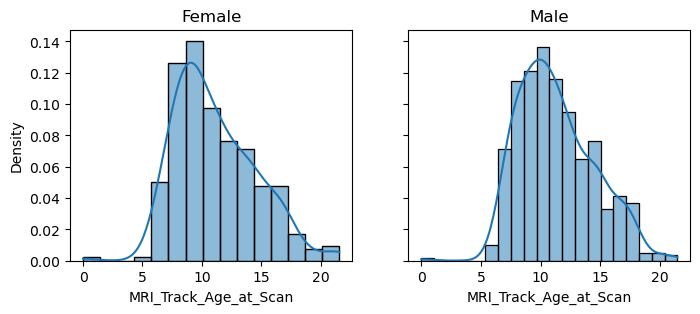

In [35]:
for quantcol in quant_meta_train.columns.tolist()[1:]:
    cat_meta_merge_df = quant_meta_train.loc[:,[quantcol,'participant_id']].merge(
        targets_train, on = 'participant_id', how = 'left'
    ).drop(columns = ['participant_id'])
    
    # Distribution of quantcol
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3], sharey=True)
    ax1 = sns.histplot(
        data=cat_meta_merge_df.loc[cat_meta_merge_df["Sex_F"] == 1,:], 
        x=quantcol,
        ax=ax1, stat="density", kde=True
    )
    ax1.set_title("Female")
    ax2 = sns.histplot(
        data=cat_meta_merge_df.loc[cat_meta_merge_df["Sex_F"] == 0,:], 
        x=quantcol,
        ax=ax2, stat="density", kde=True
    )
    ax2.set_title("Male")

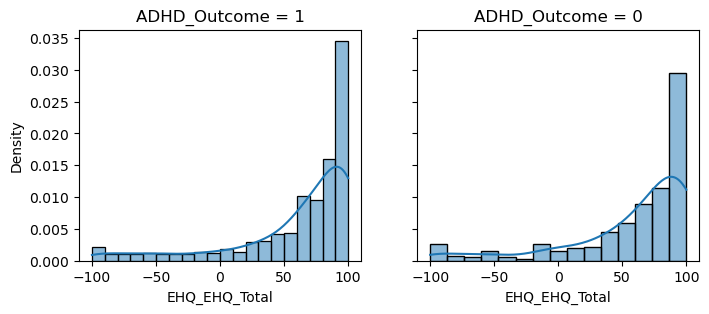

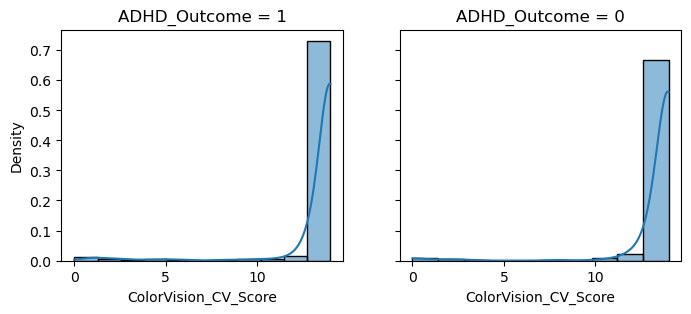

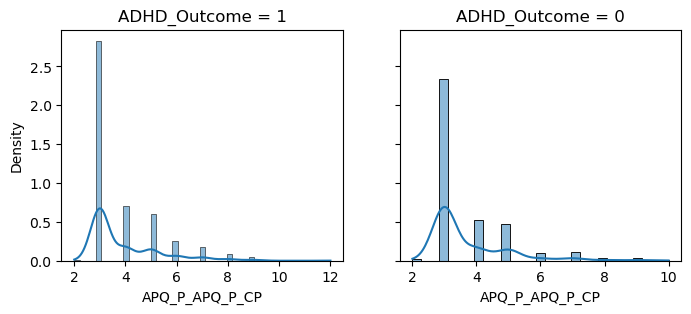

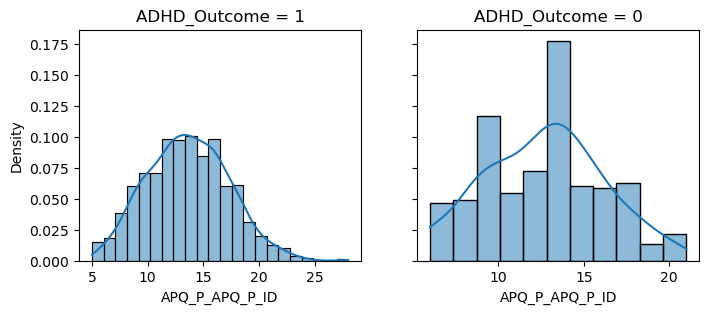

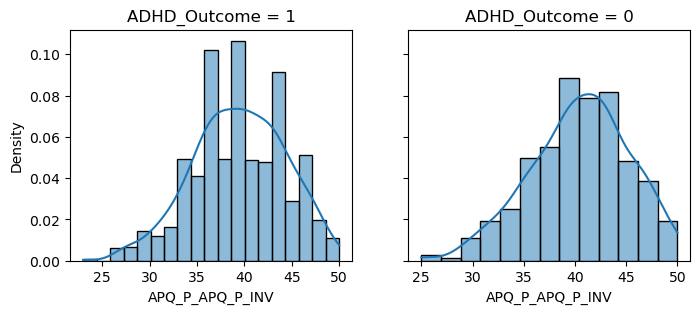

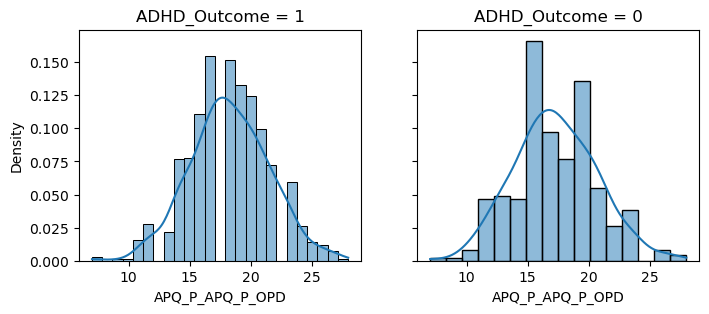

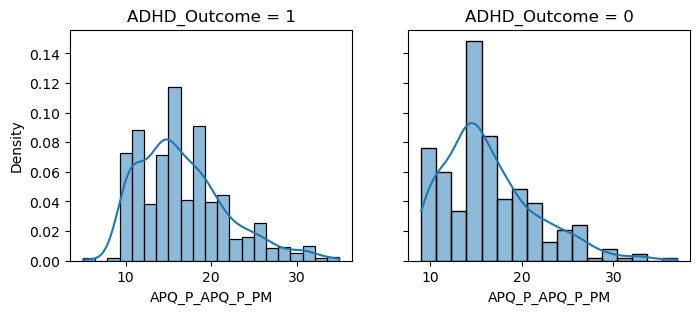

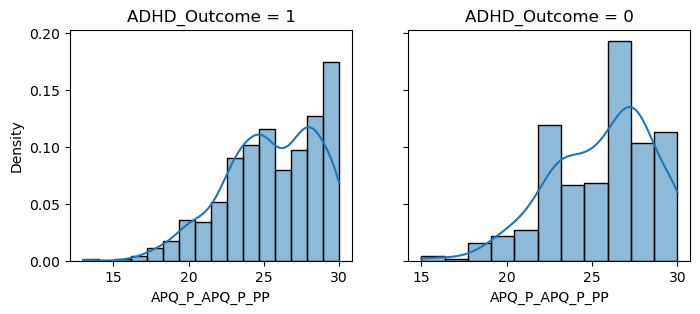

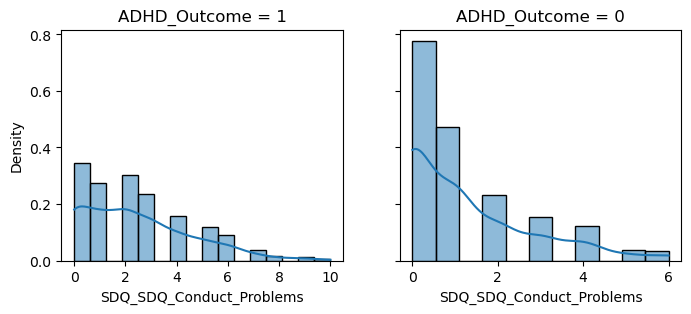

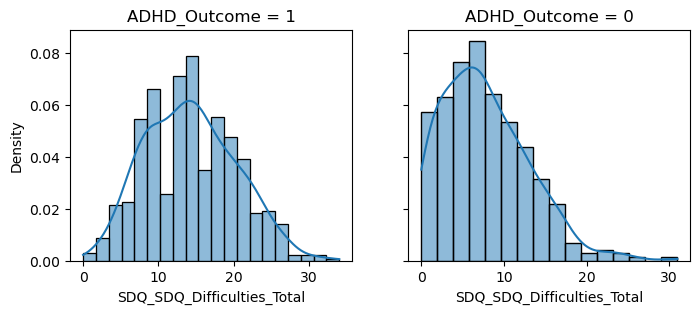

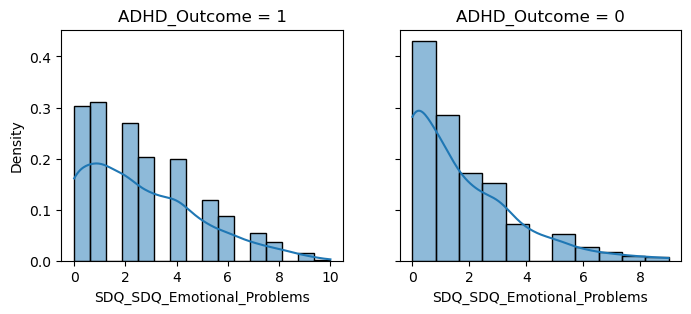

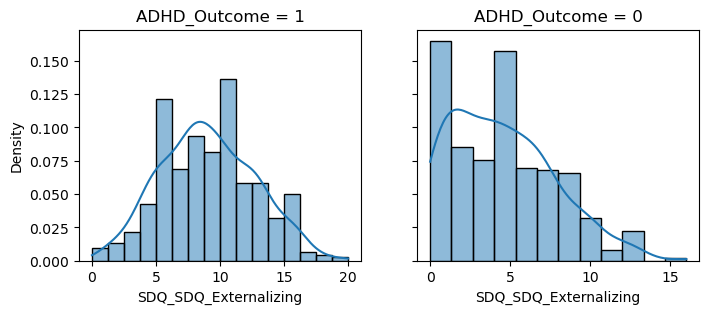

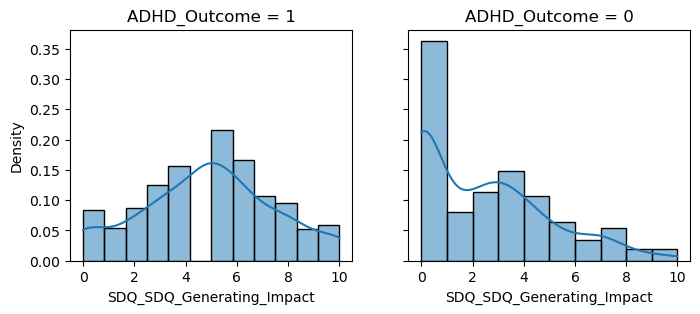

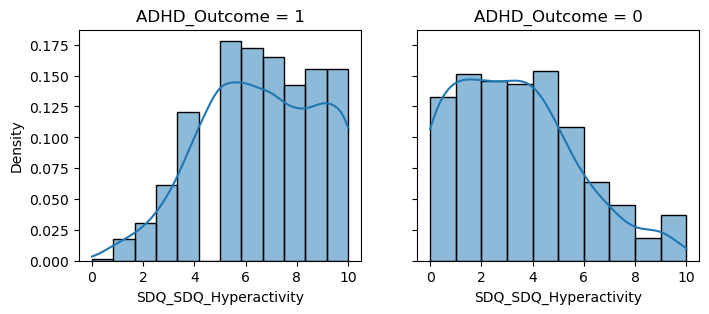

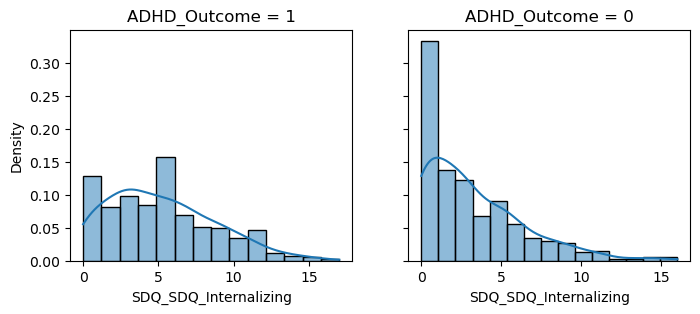

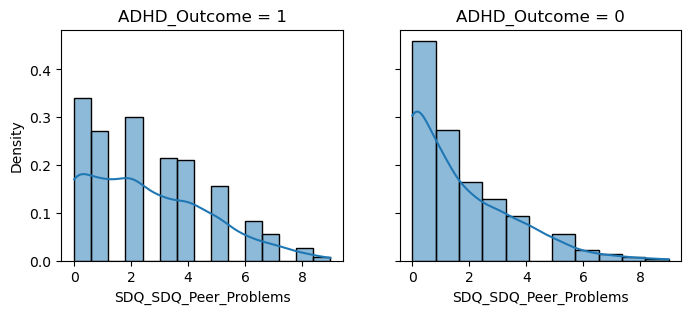

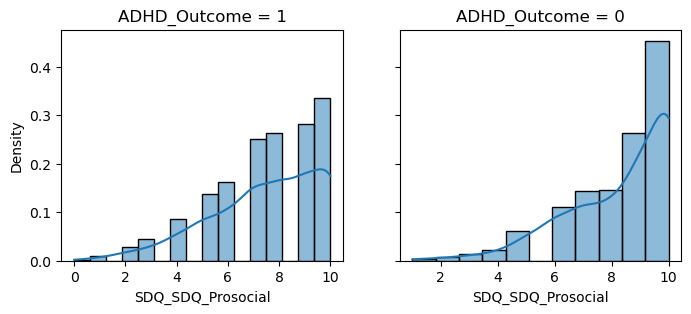

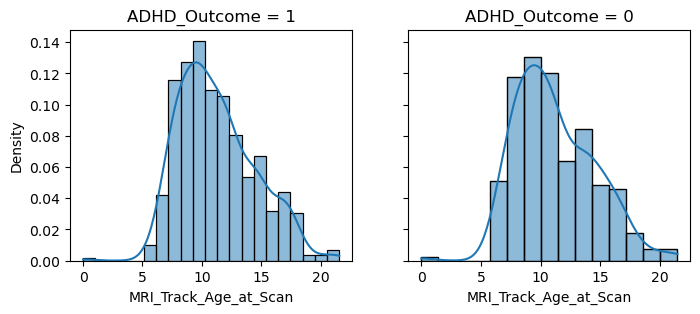

In [36]:
for quantcol in quant_meta_train.columns.tolist()[1:]:
    cat_meta_merge_df = quant_meta_train.loc[:,[quantcol,'participant_id']].merge(
        targets_train, on = 'participant_id', how = 'left'
    ).drop(columns = ['participant_id'])
    
    # Distribution of quantcol
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3], sharey=True)
    ax1 = sns.histplot(
        data=cat_meta_merge_df.loc[cat_meta_merge_df["ADHD_Outcome"] == 1,:], 
        x=quantcol,
        ax=ax1, stat="density", kde=True
    )
    ax1.set_title("ADHD_Outcome = 1")
    ax2 = sns.histplot(
        data=cat_meta_merge_df.loc[cat_meta_merge_df["ADHD_Outcome"] == 0,:], 
        x=quantcol,
        ax=ax2, stat="density", kde=True
    )
    ax2.set_title("ADHD_Outcome = 0")

In [37]:
def custom_mode(foo_series):
    count_df = foo_series.value_counts().reset_index()
    count_df.columns = ['index','count']
    max_count = count_df["count"].max()
    return(count_df.loc[count_df["count"]== max_count,"index"].median())

In [38]:
def corr_heatmap(corr_df):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

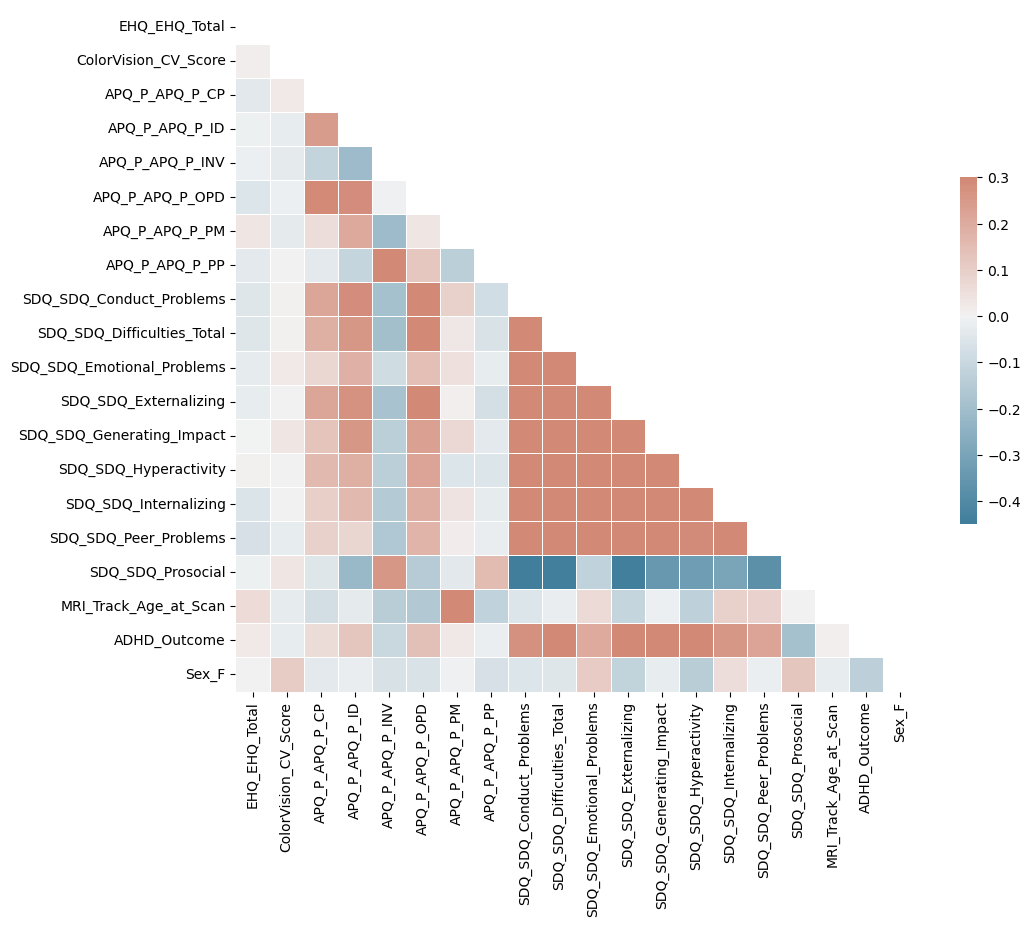

In [39]:
cat_meta_merge_df = quant_meta_train.merge(
        targets_train, on = 'participant_id', how = 'left'
    ).drop(columns = ['participant_id'])

# Replace null values in all columns with nulls with the median of the column for training data
for col in cat_meta_merge_df.columns:
    if cat_meta_merge_df[col].isna().sum() > 0:  # Check if the column has NaN values
        if cat_meta_merge_df[col].dtype in ['float64', 'int64']:  # Ensure it's numeric
            #new_col = ("%s.nullMeanImpute" % col)
            cat_meta_merge_df[col] = cat_meta_merge_df[col].fillna(cat_meta_merge_df[col].median())  # Avoid inplace
        else:
            print(f"Skipping non-numeric column: {col}")

quant_corr_df = cat_meta_merge_df.corr()

corr_heatmap(quant_corr_df)

**Notes**

Most of the quantitative features are skewed and not normally distributed so I will imput the null values using the median. The SDQ values seem the most informative for ADHD Status and they correlate strongly with one another.

## Connectome

In [40]:
print(connectome_train.shape)
#connectome_corr_df = connectome_train.drop(columns = ['participant_id']).corr()
#corr_heatmap(connectome_corr_df)

(1213, 19901)


There are a lot of features in the connectome but we can project them with unsupervised clustering such as PCA to get 80% of the explained variance.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# convert connectome to a matrix
train_connectome_matrix = connectome_train.drop(columns = ['participant_id']).to_numpy()
test_connectome_matrix = connectome_test.drop(columns = ['participant_id']).to_numpy()
print(train_connectome_matrix.shape)
print(test_connectome_matrix.shape)

# normalize the values (mean=0, sd=1)
connectome_scaler = StandardScaler()
connectome_scaler.fit(train_connectome_matrix)
train_connectome_scaler = connectome_scaler.transform(train_connectome_matrix)
test_connectome_scaler = connectome_scaler.transform(test_connectome_matrix)
print(train_connectome_scaler.shape)
print(test_connectome_scaler.shape)

# run PCA for enough components to get 80% of the explained variance
pca_connectome = PCA(n_components=.8)
pca_connectome.fit(train_connectome_scaler)
train_pca_connectome = pca_connectome.transform(train_connectome_scaler)
test_pca_connectome = pca_connectome.transform(test_connectome_scaler)

(1213, 19900)
(304, 19900)
(1213, 19900)
(304, 19900)


In [42]:
print('Explained variability per %i principal components: %.2f' % 
      (len(pca_connectome.explained_variance_ratio_), pca_connectome.explained_variance_ratio_.sum()))


Explained variability per 464 principal components: 0.80


In [43]:
train_pca_connectome_df = pd.DataFrame(data = train_pca_connectome
             , columns = ["PC"+str(x+1) for x in range(0,len(pca_connectome.explained_variance_ratio_))])
train_pca_connectome_df = pd.concat([connectome_train['participant_id'], train_pca_connectome_df],axis=1)
test_pca_connectome_df = pd.DataFrame(data = test_pca_connectome
             , columns = ["PC"+str(x+1) for x in range(0,len(pca_connectome.explained_variance_ratio_))])
test_pca_connectome_df = pd.concat([connectome_test['participant_id'], test_pca_connectome_df],axis=1)

<Figure size 640x480 with 0 Axes>

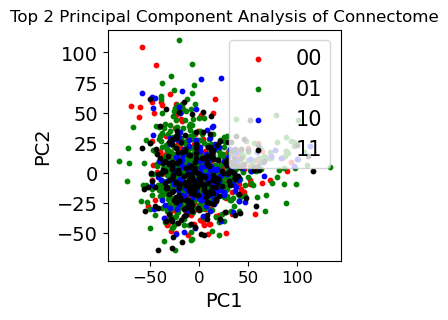

In [44]:
plt.figure()
plt.figure(figsize=(3,3))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.title("Top 2 Principal Component Analysis of Connectome",fontsize=12)
target_arr = targets_train.apply(
    lambda x: str(x["Sex_F"]) + str(x["ADHD_Outcome"]),
    axis=1)
targets = ['00', '01', '10', '11']
colors = ['r', 'g', 'b', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = target_arr == target
    plt.scatter(train_pca_connectome_df.loc[indicesToKeep, 'PC1']
               , train_pca_connectome_df.loc[indicesToKeep, 'PC2'], c = color, s = 10)

plt.legend(targets,prop={'size': 15})

# Categorical Feature Engineering

We want to edit the values in the categorical columns to be easier for the computer to comprehend

add column for single parents of type int.

In [45]:
cat_meta_train['single_parent'] = (
    (
        (cat_meta_train['Barratt_Barratt_P1_Edu'].notnull()) | 
        (cat_meta_train['Barratt_Barratt_P1_Occ'].notnull())
    ) &
    (cat_meta_train['Barratt_Barratt_P2_Edu'].isnull()) & 
    (cat_meta_train['Barratt_Barratt_P2_Occ'].isnull())
).astype(int)

In [46]:
cat_meta_test['single_parent'] = (
    (
        (cat_meta_test['Barratt_Barratt_P1_Edu'].notnull()) | 
        (cat_meta_test['Barratt_Barratt_P1_Occ'].notnull())
    ) &
    (cat_meta_test['Barratt_Barratt_P2_Edu'].isnull()) & 
    (cat_meta_test['Barratt_Barratt_P2_Occ'].isnull())
).astype(int)

add columns for:
* highest education of either parent
* highest career of either parent
* if one of the parents is a homegiver

remove columns for each individual parent

In [47]:
cat_meta_train['Barratt_Barratt_Edu_max'] = (
    cat_meta_train[['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']].max(axis=1))
cat_meta_train['Barratt_Barratt_Occ_max'] = (
    cat_meta_train[['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']].max(axis=1))
cat_meta_train['Barratt_Barratt_HomeGiver'] = (
    (cat_meta_train['Barratt_Barratt_P1_Occ'] == 0) |
     (cat_meta_train['Barratt_Barratt_P2_Occ'] == 0)
).astype(int)
cat_meta_train = cat_meta_train.drop(columns=[
    'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
])

In [48]:
cat_meta_test['Barratt_Barratt_Edu_max'] = (
    cat_meta_test[['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']].max(axis=1))
cat_meta_test['Barratt_Barratt_Occ_max'] = (
    cat_meta_test[['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']].max(axis=1))
cat_meta_test['Barratt_Barratt_HomeGiver'] = (
    (cat_meta_test['Barratt_Barratt_P1_Occ'] == 0) |
     (cat_meta_test['Barratt_Barratt_P2_Occ'] == 0)
).astype(int)
cat_meta_test = cat_meta_test.drop(columns=[
    'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
])

Impute categorical null values if necessary

In [49]:
# MRI_Track_Scan_Location: set NA to 2 since all NA individuals were at Study Site 1 
# and most people who went to study site 1 did their MRI Track Scan at Location 2
cat_meta_train['MRI_Track_Scan_Location'] = cat_meta_train['MRI_Track_Scan_Location'].fillna(2.0)

# set Ethnicity values 9-11 to NA. set null value to 2.0 (Hispanic) if Ethnicity is 1.0 (Hispanic or Latino). 
cat_meta_train.loc[(
    (cat_meta_train["PreInt_Demos_Fam_Child_Ethnicity"]==1.0) &
    (cat_meta_train["PreInt_Demos_Fam_Child_Race"].isnull())),"PreInt_Demos_Fam_Child_Race"] = 2.0
cat_meta_train.loc[cat_meta_train["PreInt_Demos_Fam_Child_Race"] > 8,"PreInt_Demos_Fam_Child_Race"] = np.nan

# set Race values 2-3 to NA. set null value to 1.0 if Ethnicity is 2.0 
cat_meta_train.loc[(
    (cat_meta_train["PreInt_Demos_Fam_Child_Race"]==2.0) &
    (cat_meta_train["PreInt_Demos_Fam_Child_Ethnicity"].isnull())),"PreInt_Demos_Fam_Child_Ethnicity"] = 1.0
cat_meta_train.loc[cat_meta_train["PreInt_Demos_Fam_Child_Ethnicity"] > 1,"PreInt_Demos_Fam_Child_Ethnicity"] = np.nan


In [50]:
# MRI_Track_Scan_Location: set NA to 2 since all NA individuals were at Study Site 1 
# and most people who went to study site 1 did their MRI Track Scan at Location 2
cat_meta_test['MRI_Track_Scan_Location'] = cat_meta_test['MRI_Track_Scan_Location'].fillna(2.0)

# set Ethnicity values 9-11 to NA. set null value to 2.0 (Hispanic) if Ethnicity is 1.0 (Hispanic or Latino). 
cat_meta_test.loc[(
    (cat_meta_test["PreInt_Demos_Fam_Child_Ethnicity"]==1.0) &
    (cat_meta_test["PreInt_Demos_Fam_Child_Race"].isnull())),"PreInt_Demos_Fam_Child_Race"] = 2.0
cat_meta_test.loc[cat_meta_test["PreInt_Demos_Fam_Child_Race"] > 8,"PreInt_Demos_Fam_Child_Race"] = np.nan

# set Race values 2-3 to NA. set null value to 1.0 if Ethnicity is 2.0 
cat_meta_test.loc[(
    (cat_meta_test["PreInt_Demos_Fam_Child_Race"]==2.0) &
    (cat_meta_test["PreInt_Demos_Fam_Child_Ethnicity"].isnull())),"PreInt_Demos_Fam_Child_Ethnicity"] = 1.0
cat_meta_test.loc[cat_meta_test["PreInt_Demos_Fam_Child_Ethnicity"] > 1,"PreInt_Demos_Fam_Child_Ethnicity"] = np.nan


# One-Hot Encoding Categorical Columns for Training Data

As we've discussed, these columns represent values across MRI metadata, demographic data, and social status.  They're already partially preprocessed, as they've been assigned numerical values to the categories within each variable. For instance, in the Parent 1 Occupation column, the number 35 might represent roles such as nurse, skilled technician, medical technician, or counselor. This grouping reduces the number of unique responses for each variable, simplifying the dataset.

We will need to take the preprocessing a step further by __one-hot encoding the categorical columns (except education level).__

One-hot encoding creates a new binary column for each unique category within a variable. For example, in the Parent 1 Occupation column with 10 possible categories (e.g., 0, 5, 10, 15, 20, etc.), one-hot encoding will generate 10 new columns: Parent_1_Occupation_0, Parent_1_Occupation_5, Parent_1_Occupation_10, and so on.

Each of these new columns will contain boolean values (True or False). For instance, if a participant's parent 1 occupation falls into category 0, the Parent_1_Occupation_0 column will have a value of True, while the other columns for this variable will be False. The same logic applies to the other categories, ensuring each participant is appropriately represented in the dataset.

__Why do we need to one-hot encode?__

1. Avoid Implying Ordinal Relationships
    * If you encode categories using numbers directly (e.g., 0, 1, 2), the algorithm might interpret these numbers as having a meaningful order or scale, which could lead to incorrect assumptions.
    * One-hot encoding eliminates this problem by assigning each category its own binary column, ensuring no ordinal relationship is implied.
2. Improve Algorithm Performance
    * Algorithms like logistic regression, decision trees, and neural networks often perform better with one-hot encoded data because it provides clear distinctions between categories.
    * Without one-hot encoding, algorithms might struggle to learn from categorical variables or produce biased results.


__Let's do it!__ 

One hot encoding is only possible on categorical variables, so let's switch our integer representations into category type variables.

Our first column of our dataset is our participant id. This is an indicator variable that identifies each patient.

This column is very important as it will be the one used to merge all of our data frames together, but, we do not want to encode this column. Why not? Well, we'd be adding 1312 unique (and useless) columns – one for each participant.

So, we will create a list of all the columns (except the individual ID and parent occupation) and label those columns_to_encode.

In [51]:
# Creating a list of all of the columns except the first
columns_to_encode = cat_meta_test.columns[1:].tolist()
columns_to_encode = [x for x in columns_to_encode if not x in ['single_parent','Barratt_Barratt_Edu_max','Barratt_Barratt_HomeGiver']]
# Print the columns to encode
print("Columns to encode:", columns_to_encode)


Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_Occ_max']


Here are the functions we'll use to encode our categorical columns and change all `True` / `False` to `1` or `0`... 

`pd.get_dummies(train_cat[columns_to_enccode], drop_first=True)`:
* Converts selected categorical columns in train_cat into one-hot encoded columns creating binary (0 or 1) columns for each category.
* The `drop_first=True` parameter avoids the "dummy variable trap" by dropping the first category for each feature,reducing redundancy in the encoded data.

`data_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))`:

*   Iterates over every element in the data_encoded DataFrame and:
    * Converts `True` to 1 and `False` to 0.
    * Leaves all other values unchanged.

In [52]:


# encoding categorical data
for col in columns_to_encode:
    cat_meta_train[col] = cat_meta_train[col].astype('category')
drop_first_cols = [x for x in columns_to_encode if cat_meta_train[x].isnull().sum()==0]
keep_allval_cols = [x for x in columns_to_encode if cat_meta_train[x].isnull().sum()>0]

train_encoded1 = pd.get_dummies(cat_meta_train[drop_first_cols], drop_first=True)
train_encoded1 = train_encoded1.map(lambda x: 1 if x is True else (0 if x is False else x))
train_encoded2 = pd.get_dummies(cat_meta_train[keep_allval_cols])
train_encoded2 = train_encoded2.map(lambda x: 1 if x is True else (0 if x is False else x))

We must reintroduce the participant ID and orginal categorical columns after encoding to ensure that our data instances are properly assigned.

The get dummies function will align the participants correctly with their respective feature variables because it respects the original index of the DataFrame, so row alignment is consistent.

Then, when concatenating data_encoded with the rest of the DataFrame train_cat.drop(columns=columns_to_encode), the rows align because pandas automatically matches by index.

In [53]:
# Combine encoded columns with the rest of the DataFrame
cat_train_final = pd.concat([cat_meta_train.drop(columns=columns_to_encode), train_encoded1, train_encoded2], axis=1)

# Make sure it looks correct
cat_train_final.head()

,participant_id,single_parent,Barratt_Barratt_Edu_max,Barratt_Barratt_HomeGiver,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,...,Barratt_Barratt_Occ_max_0.0,Barratt_Barratt_Occ_max_5.0,Barratt_Barratt_Occ_max_10.0,Barratt_Barratt_Occ_max_15.0,Barratt_Barratt_Occ_max_20.0,Barratt_Barratt_Occ_max_25.0,Barratt_Barratt_Occ_max_30.0,Barratt_Barratt_Occ_max_35.0,Barratt_Barratt_Occ_max_40.0,Barratt_Barratt_Occ_max_45.0
0,00aIpNTbG5uh,1,21.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00fV0OyyoLfw,0,21.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,04X1eiS79T4B,1,9.0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,05ocQutkURd6,0,18.0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,06YUNBA9ZRLq,1,12.0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# One-Hot Encoding Categorical Columns for Testing Data
Any machine learning problem requires testing and training data. It's essential to __ensure that any preprocessing done on the training data is also applied to the test data__ to ensure accurate model predictions.

We just encoded our categorical data to be used in our training dataframe. Now, we need to apply the same encoding steps to the categorical dataframe in the testing data. 

Let's follow the same preprocessing steps that we applied to the categorical training data, and apply them to the categorical testing data.

Encode the categorical testing data.

In [54]:
# encoding categorical data
for col in columns_to_encode:
    cat_meta_test[col] = cat_meta_test[col].astype('category')
drop_first_cols = [x for x in columns_to_encode if cat_meta_test[x].isnull().sum()==0]
keep_allval_cols = [x for x in columns_to_encode if cat_meta_test[x].isnull().sum()>0]

test_encoded1 = pd.get_dummies(cat_meta_test[drop_first_cols], drop_first=True)
test_encoded1 = test_encoded1.map(lambda x: 1 if x is True else (0 if x is False else x))
test_encoded2 = pd.get_dummies(cat_meta_test[keep_allval_cols])
test_encoded2 = test_encoded2.map(lambda x: 1 if x is True else (0 if x is False else x))

In [55]:
# Combine encoded columns with the rest of the DataFrame
cat_test_final = pd.concat([cat_meta_test.drop(columns=columns_to_encode), test_encoded1, test_encoded2], axis=1)

# Make sure it looks correct
cat_test_final.head()

,participant_id,single_parent,Barratt_Barratt_Edu_max,Barratt_Barratt_HomeGiver,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,Basic_Demos_Study_Site_5,MRI_Track_Scan_Location_4,...,Barratt_Barratt_Occ_max_0.0,Barratt_Barratt_Occ_max_5.0,Barratt_Barratt_Occ_max_10.0,Barratt_Barratt_Occ_max_15.0,Barratt_Barratt_Occ_max_20.0,Barratt_Barratt_Occ_max_25.0,Barratt_Barratt_Occ_max_30.0,Barratt_Barratt_Occ_max_35.0,Barratt_Barratt_Occ_max_40.0,Barratt_Barratt_Occ_max_45.0
0,Cfwaf5FX7jWK,0,21.0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,vhGrzmvA3Hjq,0,21.0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,ULliyEXjy4OV,0,21.0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,LZfeAb1xMtql,0,21.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,EnFOUv0YK1RG,0,21.0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Merging Data Frames

Now we have categorical data frames for both our training and test datasets that are both ready to be merged with our remaining variables: the functional connectome matrices and quantitative data. The result of merging will be two final dataframes: `train_df` and `test_df`.

All the dataframes include a `participant_id` variable, which serves as the unique identifier for each patient. As the only common variable across the datasets, this will be used to merge the dataframes.

The pandas merge function can only merge two dataframes. So, we'll merge our encoded train categorical dataframe with our training functional connectome matrices first, then we'll combine that merged data frame with our training quantitative dataframe. 

In [56]:
# test_pca_connectome_df
train_cat_FCM = pd.merge(cat_train_final, connectome_train, on = 'participant_id')
train_df = pd.merge(cat_train_final, quant_meta_train, on = 'participant_id')
train_df = pd.merge(train_df, train_pca_connectome_df, on = 'participant_id')
train_df.head()

,participant_id,single_parent,Barratt_Barratt_Edu_max,Barratt_Barratt_HomeGiver,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,...,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
0,00aIpNTbG5uh,1,21.0,0,0,0,0,1,0,0,...,0.129215,-1.191306,1.812237,-0.105391,1.156402,1.451116,-1.437001,2.895261,1.858880,0.943877
1,00fV0OyyoLfw,0,21.0,1,0,1,0,0,0,0,...,-0.617199,6.609571,-5.952360,2.185165,-2.262471,5.571127,-2.933146,1.880191,0.362809,0.553217
2,04X1eiS79T4B,1,9.0,1,0,1,0,0,0,0,...,-0.115414,-6.225548,4.017064,2.463110,4.890961,-6.419114,2.422712,-0.855045,4.032222,0.553574
3,05ocQutkURd6,0,18.0,1,0,0,1,0,0,0,...,1.645691,1.472859,-6.685308,-5.745176,-2.458562,2.390865,-3.318444,-4.382209,-3.838426,-4.982812
4,06YUNBA9ZRLq,1,12.0,1,0,0,1,0,0,0,...,-0.926254,-1.768150,1.055723,-1.292324,-0.452534,5.029678,1.648175,-0.342974,-3.411046,1.685907


We're almost done with our training dataframe! You may have noticed that there is one dataframe left in our training data that we have not merged... the solutions!

When training a machine learning model you have the following dataframes – 
- An `X_train ` dataframe containing the feature variables
- A `Y_train` dataframe containing the target variables

We have just created our `X_train` dataframe. 

Since the testing data doesn't contain solutions, we just need one feature variable dataframe for the test data: `X_test`. 

Now, let's merge together the feature variables for our testing data, the same way we did for our training data.

In [57]:
test_cat_FCM = pd.merge(cat_test_final, connectome_test, on = 'participant_id')
test_df = pd.merge(cat_test_final, quant_meta_test, on = 'participant_id')
test_df = pd.merge(test_df, test_pca_connectome_df, on = 'participant_id')
test_df.head()

,participant_id,single_parent,Barratt_Barratt_Edu_max,Barratt_Barratt_HomeGiver,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,Basic_Demos_Study_Site_5,MRI_Track_Scan_Location_4,...,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
0,Cfwaf5FX7jWK,0,21.0,0,0,0,1,0,0,1,...,-3.596407,1.425583,1.448688,2.088227,2.091523,-3.737311,-2.582946,-2.192258,-1.197435,3.916691
1,vhGrzmvA3Hjq,0,21.0,0,0,0,0,1,0,1,...,1.941471,3.172305,-2.188516,1.117414,-0.719611,-0.757223,-2.146268,-1.286287,2.045764,2.978238
2,ULliyEXjy4OV,0,21.0,0,0,0,1,0,0,1,...,-2.424265,-1.191087,0.695843,3.827316,3.367353,-0.724493,2.807786,2.900416,-0.621076,1.941642
3,LZfeAb1xMtql,0,21.0,0,0,0,1,0,0,0,...,-0.312824,-2.053418,-0.250542,-0.743932,2.158111,0.498961,-1.091209,1.100269,1.216505,-1.148541
4,EnFOUv0YK1RG,0,21.0,1,0,0,1,0,0,1,...,1.092514,0.358361,-2.350923,0.288560,0.160688,-3.793878,-2.998285,2.079861,-3.505164,1.928033


### Handling NA values

Our train and test dataframes are nearly done! Just one last thing – Remember when we looked at the value counts for all the columns in the training data and saw that some columns had null values?

Well, null values can introduce bias, reduce accuracy, and make it difficult for models to draw meaningful insights or predictions. Many machine learning algorithms assume complete datasets and struggle with missing values, leading to inaccurate or unreliable results. As such, we need to handle these missing values in both our training AND test datasets to ensure optimal model performance.

There are many approaches to handle missing values, and the best method often depends on your dataset and chosen machine learning model.

First, let's check out how many null values we're dealing with.

In [58]:
print(train_df.isna().sum())
print(train_df.isna().sum().sum())

participant_id                   0
single_parent                    0
Barratt_Barratt_Edu_max         13
Barratt_Barratt_HomeGiver        0
Basic_Demos_Enroll_Year_2016     0
                                ..
PC460                            0
PC461                            0
PC462                            0
PC463                            0
PC464                            0
Length: 516, dtype: int64
562


In [59]:
# Replace null values in all columns with nulls with the median of the column for training data
for col in train_df.columns:
    if train_df[col].isna().sum() > 0:  # Check if the column has NaN values
        if train_df[col].dtype in ['float64', 'int64']:  # Ensure it's numeric
            train_df[col] = train_df[col].fillna(train_df[col].median())  # Avoid inplace
        else:
            print(f"Skipping non-numeric column: {col}")

print(train_df.isna().sum().sum()) # should now be zero

0


### X Train and Y Train

For any machine learning model, you need an `X_train` dataset, which contains the feature variables used to make predictions about the target variables – in this case, ADHD diagnosis and gender. Our feature variables include categorical columns, quantitative variables, and functional connectome matrices. We have prepared our `X_train` dataframe by encoding categorical variables, merging dataframes, and handling missing values by filling in NAs.

In addition to `X_train`, we also need `Y_train`, the dataset containing the target variables, to train the model. The target variables allow the model to learn the patterns in the feature variables that lead to specific outcomes for ADHD diagnosis and gender. This relationship is what enables the model to make accurate predictions when applied to new data.

So the first step we will take in coding is loading in the training solutions dataframe this will be our `Y_train`.

Both our `X_train` and `Y_train` datasets include the `participant_id` column, which serves as an identifier for each patient. 

Since this column is of type category and machine learning models require numerical data (`int` or `float`), it cannot be used during training. Additionally, it is not relevant for model learning. 

Therefore, we will remove the `participant_id` column from both dataframes before training the machine learning model.

In [60]:
train_df.to_csv('X_train.csv', index=False)
test_df.to_csv('X_test.csv', index=False)

#X_train = train_df.drop(columns = ['participant_id'])
#Y_train = targets_train.drop(columns = ['participant_id'])


In [76]:
metadata_df = pd.merge(cat_train_final, quant_meta_train, on = 'participant_id')
# metadata_df.to_csv('metadata.csv', index = False)
metadata_df

,participant_id,single_parent,Barratt_Barratt_Edu_max,Barratt_Barratt_HomeGiver,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,1,21.0,0,0,0,0,1,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,0,21.0,1,0,1,0,0,0,0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,1,9.0,1,0,1,0,0,0,0,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,0,18.0,1,0,0,1,0,0,0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,1,12.0,1,0,0,1,0,0,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,0,15.0,0,0,0,0,1,0,0,...,5.0,20.0,5.0,13.0,5.0,8.0,7.0,2.0,8.0,11.272986
1209,zwXD5v17Rx01,0,21.0,0,0,0,1,0,0,0,...,2.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0,7.0,7.364020
1210,zWzLCi3NTBTd,0,21.0,0,0,0,1,0,0,0,...,2.0,14.0,3.0,9.0,3.0,7.0,5.0,2.0,9.0,9.962126
1211,Zy9GTHDxUbXU,0,18.0,0,0,0,0,1,0,0,...,1.0,10.0,0.0,8.0,5.0,7.0,2.0,2.0,7.0,NaN


In [75]:
metadata_df_test = pd.merge(cat_test_final, quant_meta_test, on = 'participant_id')
metadata_df_test.to_csv('metadata_test.csv', index = False)
metadata_df_test.shape

(304, 47)

## Flattened FCM

In [62]:
def flatten_to_square_matrix(flattened_fcm, size=200):
    # Ensure the length of the flattened matrix corresponds to the upper triangular part of a 192x192 matrix
    num_elements = len(flattened_fcm)
    expected_elements = (size * (size - 1)) // 2

    if num_elements != expected_elements:
        raise ValueError(f"Flattened matrix size mismatch. Expected {expected_elements} elements, got {num_elements}")

    # Initialize a square matrix (size x size) filled with zeros
    matrix = np.zeros((size, size))

    # Extract the upper triangular indices (i, j) where i < j
    indices = np.triu_indices(size, k=1)  # k=1 excludes diagonal (i != j)

    # Assign the flattened values to the upper triangular part of the matrix
    matrix[indices] = flattened_fcm
    matrix.T[indices] = flattened_fcm  # Symmetric part: Copy to the lower triangle

    return matrix

# Example for the first participant
flattened_fcm = connectome_train.iloc[0, 1:].values  # Skip the participant_id column
fcm_matrix = flatten_to_square_matrix(flattened_fcm)
print(fcm_matrix.shape)  # Should print (192, 192)


(200, 200)


In [63]:
# Assuming train_FCM is a pandas DataFrame with participant IDs and flattened FCMs
connectivity_matrices = []

for i in range(len(connectome_train)):
    flattened_fcm = connectome_train.iloc[i, 1:].values  # Skip the participant_id column
    fcm_matrix = flatten_to_square_matrix(flattened_fcm)
    connectivity_matrices.append(fcm_matrix)

connectivity_matrices = np.array(connectivity_matrices)
print(connectivity_matrices.shape)  # Should print (N, 200, 200), where N is the number of participants


connectivity_matrices_test = []

for i in range(len(connectome_test)):
    flattened_fcm = connectome_test.iloc[i, 1:].values  # Skip the participant_id column
    fcm_matrix = flatten_to_square_matrix(flattened_fcm)
    connectivity_matrices_test.append(fcm_matrix)

connectivity_matrices_test = np.array(connectivity_matrices_test)
print(connectivity_matrices_test.shape) 

(1213, 200, 200)
(304, 200, 200)


In [64]:
connectivity_matrices.to_csv('FCM_train.csv',index=False)
connectivity_matrices_test.to_csv('FCM_test.csv',index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'